# **Crypto market capitalization forecast based on S&P 500.**

## **Abstract**
   Abstract here. Give an executive summary of your project: goal, methods, results, conclusions. Usually no more than 200 words.


## **Introduction**

Here you have to explain the problem that you are solving. Explain why it is important, and what are the main challenges. Mention previous attempts (add papers as references) to solve it. Mainly focus on the techniques closely related to our approach. Briefly describe your approach and explain why it is promising for solving the addressed problem. Mention the dataset and the main results achieved.

In this section, you can add **text** and **figures**.

## **Methodology**
Describe the important steps you took to achieve your goal. Focus more on the most important steps (preprocessing, extra features, model aspects) that turned out to be important. Mention the original aspects of the project and state how they relate to existing work.

In this section, you can add **text** and **figures**. For instance, it is strongly suggested to add a picture of the best machine learning model that you implemented to solve your problem (and describe it).


### **Preprocessing**

The first step in our methodology involved preprocessing the raw data from 2 sources: Kaggle and CoinCodex. We will be using the Kaggle data for everything that is related to the S&P500, and CoinCodex for everything related crypto. For the cryptocurrency data, we focused on key features such as Date, Volume, and Marketcap. Similarly, for the S&P500 data, we retained relevant columns like Date, Open, High, Low, Close, Volume, and additional info regarding the fear index (VIX). The datasets were cleaned to handle missing values, if any, unwanted data and the Date columns were standardized to ensure compatibility for merging.

First Let's import the necessary libraries that we need for the project and define some constants!
Run the code below...


In [8]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import math

In [9]:
DATA_PATH = 'Data/'
STOCK_DATA_PATH_RAW = 'Data/StockData/RawData/'
STOCK_DATA_PATH_PROCESSED = 'Data/StockData/preProcessedData/'
CRYPTO_DATA_PATH_RAW = 'Data/CryptoData/RawData/'
CRYPTO_DATA_PATH_PROCESSED = 'Data/CryptoData/PreProcessedData/'
KAGGLE_DATA_PATH = 'Data/KaggleData/'
START_DATE = '2018-01-18'
END_DATE = '2025-04-04'

Once the libraries imported, we can now load the S&P500 data, and an example of crypto data to take a look at the first few rows along with some additional info by running the code below.

In [10]:
def load_data(filename: str, date_col: str, date_format: str) -> pd.DataFrame:
    """
    Loads a CSV file into a pandas DataFrame and parses the date column.

    Args:
        filename (str): Name of the CSV file.
        date_col (str): Name of the date column.
        date_format (str): Format of the date in the CSV.

    Returns:
        pd.DataFrame: Processed DataFrame with parsed dates.
    """
    filepath = os.path.join(STOCK_DATA_PATH_RAW, filename)
    df = pd.read_csv(filepath)
    df[date_col] = pd.to_datetime(df[date_col], format=date_format)
    return df

stock_df = load_data('S&P500_Historical_Data.csv', 'Date', '%Y-%m-%d')
vix_df = load_data('VIX_Historical_Data.csv', 'Date', '%m/%d/%Y')

for name, df in zip(["Stock", "VIX"], [stock_df, vix_df]):
    print(f"\n{name} Dataset ==> Min Date: {df['Date'].min()} / Max Date: {df['Date'].max()}")



Stock Dataset ==> Min Date: 2017-01-03 00:00:00 / Max Date: 2025-04-04 00:00:00

VIX Dataset ==> Min Date: 1990-01-02 00:00:00 / Max Date: 2025-04-04 00:00:00


In [11]:
stock_df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2025-04-04,"5,074.08","5,292.14","5,292.14","5,069.90",NaN,-5.97%
1,2025-04-03,"5,396.52","5,492.74","5,499.53","5,390.83",NaN,-4.84%
2,2025-04-02,"5,670.97","5,580.76","5,695.31","5,571.48",NaN,0.67%
3,2025-04-01,"5,633.07","5,597.53","5,650.57","5,558.52",NaN,0.38%
4,2025-03-31,"5,611.85","5,527.91","5,627.56","5,488.73",NaN,0.55%


In [12]:
vix_df.head()

,Date,Open,High,Low,Close
0,1990-01-02,17.24,17.24,17.24,17.24
1,1990-01-03,18.19,18.19,18.19,18.19
2,1990-01-04,19.22,19.22,19.22,19.22
3,1990-01-05,20.11,20.11,20.11,20.11
4,1990-01-08,20.26,20.26,20.26,20.26


In [13]:
btc_df = pd.read_csv(os.path.join(CRYPTO_DATA_PATH_RAW, 'BTC.csv'))
btc_df.head()

,Start,End,Open,High,Low,Close,Volume,Market Cap
0,2025-04-06,2025-04-07,83533.45,83704.76,77296.39,78310.34,2.974769e+10,1.626852e+12
1,2025-04-05,2025-04-06,83769.12,84219.70,82384.97,83582.03,5.424886e+10,1.654110e+12
2,2025-04-04,2025-04-05,83259.08,84676.27,81767.53,83879.86,6.263226e+10,1.654911e+12
3,2025-04-03,2025-04-04,82259.03,83781.70,81307.75,83199.95,7.766843e+10,1.643472e+12
4,2025-04-02,2025-04-03,85170.68,87898.01,82487.40,82548.31,5.237611e+10,1.688190e+12


#### **Crypto Data**

Great, let's now tackle our raw crypto data.  
After some research and many hours of trying to find the best balance between variety of cryptos and the amount of data that can be used, I have decided to include 14 cryptos from the top 100 where the data stretches from 2018 to 2025.  

Let us take a look at an example of crypto data that we have:

**Note**: We have a CSV for every crypto. (14 CSVs total)

Let us standardize our timeframe now. From all the CSVs we have, we can see that our range should be from 2018-1-18 to 2025-04-04 to match the maximum date of the stock market data and the minimum date of the crypto CSVs.

In [14]:
date_range = pd.date_range(start=START_DATE, end=END_DATE, freq='D')
processed_dfs = {}  # Dictionary to store processed DataFrames (key: symbol, value: DataFrame)

for filename in os.listdir(CRYPTO_DATA_PATH_RAW):
    try:
        raw_path = os.path.join(CRYPTO_DATA_PATH_RAW, filename)
        df = pd.read_csv(raw_path)
        df['Start'] = pd.to_datetime(df['Start'])
        df = df[df['Start'].isin(date_range)]
        df = df.sort_values('Start')
        
        symbol = filename.split('.')[0]  # Extract symbol (e.g., 'BTC' from 'BTC.csv')
        processed_dfs[symbol] = df # Store processed DataFrame in the dictionary
        
    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")

print("All files processed!")

All files processed!


Let us now check for some missing values in the most interesting features!

In [15]:
# Check for missing/invalid values (0, -1, or NaN) in key columns
for symbol, df in processed_dfs.items():
    invalid_volume = ((df['Volume'] == 0) | (df['Volume'] == -1) | (df['Volume'].isna())).sum()
    invalid_market_cap = ((df['Market Cap'] == 0) | (df['Market Cap'] == -1) | (df['Market Cap'].isna())).sum()
    
    if invalid_volume > 0 or invalid_market_cap > 0:
        print(f"\n{symbol}:")
        print(f"  ==> Missing/Invalid 'Volume' values: {invalid_volume}")
        print(f"  ==> Missing/Invalid 'Market Cap' values: {invalid_market_cap}")

print("\nCheck complete!")


BNB:
  ==> Missing/Invalid 'Volume' values: 0
  ==> Missing/Invalid 'Market Cap' values: 133

EOS:
  ==> Missing/Invalid 'Volume' values: 0
  ==> Missing/Invalid 'Market Cap' values: 133

Check complete!


After inspecting the dataframes of each token, we can see that there are some data points of market cap data missing in BNB and EOS.  
We will use data from kaggle to fill that in.  

In [16]:
def update_market_caps(processed_dfs, all_crypto_file):
    all_crypto_df = pd.read_csv(all_crypto_file)
    
    for symbol, crypto_df in processed_dfs.items():
        try:
            crypto_df['Start'] = pd.to_datetime(crypto_df['Start'])
            symbol_data = all_crypto_df[all_crypto_df['Symbol'] == symbol].copy()
            symbol_data['Date'] = pd.to_datetime(symbol_data['Date'], format='%d-%m-%Y %H:%M')
            
            # Normalize dates for comparison
            crypto_df['Start_date'] = crypto_df['Start'].dt.normalize()
            symbol_data['Date_date'] = symbol_data['Date'].dt.normalize()
            
            # Map market caps by date
            market_cap_dict = dict(zip(symbol_data['Date_date'], symbol_data['Marketcap']))
            
            # Update missing market caps
            updated_count = 0
            for index, row in crypto_df.iterrows():
                if row['Market Cap'] in [0.0, -1.0]:
                    start_date = row['Start_date']
                    if start_date in market_cap_dict:
                        crypto_df.at[index, 'Market Cap'] = market_cap_dict[start_date]
                        updated_count += 1
            
            crypto_df.drop(columns=['Start_date'], inplace=True)
            
            if updated_count > 0:
                print(f"{symbol}: Updated {updated_count} market cap values")
                
        except Exception as e:
            print(f"Error processing {symbol}: {str(e)}")

update_market_caps(processed_dfs, KAGGLE_DATA_PATH + 'All_Crypto.csv')
print("\nMarket caps updated!")

BNB: Updated 133 market cap values
EOS: Updated 133 market cap values

Market caps updated!


Nice, now our crypto data is complete within the time range of 2018 to 2025.  
Let us now work on dropping the unwated features and making the merged crypto dataset.

In [17]:
# Merge all DataFrames and add 'symbol' column
merged_df = pd.concat(
    [df.assign(symbol=symbol) for symbol, df in processed_dfs.items()],
    ignore_index=True
)

# Drop unwanted columns and rename
merged_df.drop(columns=['End', 'Low', 'High', 'Open', 'Close'], inplace=True)
merged_df.rename(columns={'Start': 'Date', 'Market Cap': 'MarketCap'}, inplace=True)

# Save the final merged file
output_file = 'Crypto.csv'
merged_df.to_csv(os.path.join(CRYPTO_DATA_PATH_PROCESSED, output_file), index=False)
print(f"Merged data saved to {output_file}")

Merged data saved to Crypto.csv


Let us now aggregate the data to have the daily total Market Cap and Voume.

In [18]:
# Aggregate the data by date so that each date has the sum of market caps and volumes for all cryptocurrencies
def aggregate_crypto_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregates crypto data by date, summing 'Volume' and 'MarketCap',
    and renames the columns for clarity.
    
    Args:
        df (pd.DataFrame): The input DataFrame with 'Date', 'Volume', and 'MarketCap' columns.
    
    Returns:
        pd.DataFrame: Aggregated DataFrame with 'Date', 'Crypto_Volume', and 'Crypto_Market_Cap'.
    """
    aggregated_df = (
        df.groupby('Date', as_index=False)
        .agg({'Volume': 'sum', 'MarketCap': 'sum'})
        .rename(columns={'Volume': 'Crypto_Volume', 'MarketCap': 'Crypto_Market_Cap'})
    )

    return aggregated_df

In [19]:
crypto_df = aggregate_crypto_data(merged_df)
crypto_df.to_csv(os.path.join(CRYPTO_DATA_PATH_PROCESSED, 'Aggregated_Crypto.csv'), index=False)
print("Aggregated data saved to Aggregated_Crypto.csv")

Aggregated data saved to Aggregated_Crypto.csv


#### **S&P500 Data**

Let us now process the stock market data.  
We need to keep in mind that the stock market closes on the weekends. Thus, for the sake of this project, we will assume that the last available price (Friday’s) carries over to Saturday and Sunday since stock prices don’t change on weekends.  
We will use Forward fill to accomplish this.  
This will keep the dataset aligned with the crypto data. Also, it reflects the reality that stock prices remain unchanged on weekends.
Same thing will be done to the VIX data frame as well.

Let's define some helper functions...

In [20]:
def handle_closed_weekends(df: pd.DataFrame, start_date: str, end_date: str, date_col: str = 'Date') -> pd.DataFrame:
    """
    Processes S&P 500 data to:
    1. Filter date range
    2. Expand to include weekends
    3. Forward-fill price columns
    4. Set 'Change_%' to 0.0 on weekends
    5. Ensure proper datetime format
    
    Args:
        df: DataFrame with market data
        start_date: Start date (YYYY-MM-DD)
        end_date: End date (YYYY-MM-DD)
        date_col: Name of date column
    
    Returns:
        Processed DataFrame with continuous daily data
    """
    df[date_col] = pd.to_datetime(df[date_col])
    filtered_df = df[(df[date_col] >= start_date) & (df[date_col] <= end_date)].copy()
    
    full_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    if 'S&P500_Change_%' in filtered_df.columns:
        filtered_df['S&P500_Change_%'] = (
            filtered_df['S&P500_Change_%']
            .astype(str)
            .str.replace('%', '')
            .replace('', '0')
            .astype(float)
        )
    
    reindexed_df = (
        filtered_df
        .set_index(date_col)
        .reindex(full_dates)
    )
    
    price_cols = [col for col in reindexed_df.columns if col != 'Change_%']
    
    reindexed_df[price_cols] = reindexed_df[price_cols].ffill()
    
    if 'S&P500_Change_%' in reindexed_df.columns:
        reindexed_df['S&P500_Change_%'] = reindexed_df['S&P500_Change_%'].fillna(0.0)
    
    result = reindexed_df.reset_index().rename(columns={'index': date_col})
    
    result[date_col] = pd.to_datetime(result[date_col])
    
    return result

def preprocess_sp500(df: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
    df = df.drop(columns=['Vol.'], errors='ignore')
    df['Open'] = df['Open'].str.replace(',', '').astype(float)
    df['High'] = df['High'].str.replace(',', '').astype(float)
    df['Low'] = df['Low'].str.replace(',', '').astype(float)
    df['Price'] = df['Price'].str.replace(',', '').astype(float)
    df = df.rename(columns={
            'Open': 'S&P500_Open',
            'High': 'S&P500_High',
            'Low': 'S&P500_Low',
            'Price': 'S&P500_Close',
            'Change %': 'S&P500_Change_%'
    })
    
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        df['Date'] = pd.to_datetime(df['Date'])
    
    processed = handle_closed_weekends(
        df=df,
        start_date=start_date,
        end_date=end_date,
        date_col='Date'
    )
    
    return processed

def preprocess_vix(df: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
    df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.rename(columns={
            'Open': 'VIX_Open',
            'High': 'VIX_High',
            'Low': 'VIX_Low',
            'Close': 'VIX_Close'
        })
    
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    df = (
        df.set_index('Date')
        .reindex(date_range)
        .ffill()
        .reset_index()
        .rename(columns={'index': 'Date'})
    )
    
    return df

In [21]:
# Process both datasets
stock_df = preprocess_sp500(stock_df, START_DATE, END_DATE)
vix_df = preprocess_vix(vix_df, START_DATE, END_DATE)

# Print results
print(f"S&P500 dataset: {stock_df['Date'].min()} to {stock_df['Date'].max()} "
      f"with {len(stock_df)} rows")
print(f"Columns: {stock_df.columns.tolist()}\n")

print(f"VIX dataset: {vix_df['Date'].min()} to {vix_df['Date'].max()} "
      f"with {len(vix_df)} rows")
print(f"Columns: {vix_df.columns.tolist()}")

S&P500 dataset: 2018-01-18 00:00:00 to 2025-04-04 00:00:00 with 2634 rows
Columns: ['Date', 'S&P500_Close', 'S&P500_Open', 'S&P500_High', 'S&P500_Low', 'S&P500_Change_%']

VIX dataset: 2018-01-18 00:00:00 to 2025-04-04 00:00:00 with 2634 rows
Columns: ['Date', 'VIX_Open', 'VIX_High', 'VIX_Low', 'VIX_Close']


In [22]:
# Save the processed stock and VIX data
stock_df.to_csv(os.path.join(STOCK_DATA_PATH_PROCESSED, 'S&P500.csv'), index=False)
vix_df.to_csv(os.path.join(STOCK_DATA_PATH_PROCESSED, 'VIX.csv'), index=False)
print("Processed stock and VIX data saved!")

Processed stock and VIX data saved!


#### **Merging and Unification of the datasets**

Perfect, now that we have cleaned the data, we still have to unify our datasets into one before starting to play with models.  

In [23]:
temp_df = pd.merge(stock_df, vix_df, on='Date', how='inner')
main_df = pd.merge(temp_df, crypto_df, on='Date', how='inner')
main_df.to_csv(os.path.join(DATA_PATH, 'MainData.csv'), index=False)
main_df.head()

,Date,S&P500_Close,S&P500_Open,S&P500_High,S&P500_Low,S&P500_Change_%,VIX_Open,VIX_High,VIX_Low,VIX_Close,Crypto_Volume,Crypto_Market_Cap
0,2018-01-18,2798.0,2802.4,2805.8,2792.6,-0.16,12.01,12.40,11.62,12.22,3.397555e+10,4.182316e+11
1,2018-01-19,2810.3,2802.6,2810.3,2798.1,0.44,12.30,12.33,11.18,11.27,2.290271e+10,4.241106e+11
2,2018-01-20,2810.3,2802.6,2810.3,2798.1,0.44,12.30,12.33,11.18,11.27,1.770756e+10,4.568364e+11
3,2018-01-21,2810.3,2802.6,2810.3,2798.1,0.44,12.30,12.33,11.18,11.27,1.591606e+10,4.235859e+11
4,2018-01-22,2833.0,2809.2,2833.0,2808.1,0.81,11.59,11.62,10.84,11.03,1.512720e+10,4.032085e+11


#### **Feature Engineering**

Now that we have our main dataset, we can add meaningful features to it that will probably help with the training of the models.  
Let's define some helper functions.

In [24]:
# Help model to learn seasonal or cyclic patterns
def add_seasonal_features(df: pd.DataFrame, date_col: str) -> pd.DataFrame:
    """
    Adds seasonal features to the DataFrame based on the date column.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        date_col (str): The name of the date column.
    
    Returns:
        pd.DataFrame: DataFrame with added seasonal features.
    """
    df['Year'] = df[date_col].dt.year
    df['Month'] = df[date_col].dt.month
    df['Day'] = df[date_col].dt.day
    df['DayOfWeek'] = df[date_col].dt.dayofweek
    df['IsWeekend'] = df['DayOfWeek'] >= 5
    
    return df

# Add rolling statistics
def add_rolling_statistics(df: pd.DataFrame, window: int = 9) -> pd.DataFrame:
    """
    Adds rolling statistics to the DataFrame.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        window (int): The rolling window size.
    
    Returns:
        pd.DataFrame: DataFrame with added rolling statistics.
    """
    df['Market_Cap_STD'] = df['Crypto_Market_Cap'].rolling(window=window).std()
    df['SP500_EMA'] = df['S&P500_Close'].ewm(span=window, adjust=False).mean()  
    windows = [20, 50, 100] 
    for w in windows:
        df[f'SP500_SMA_{w}'] = df['S&P500_Close'].rolling(window=w).mean()
    return df

# Add lag features
def add_lag_features(df: pd.DataFrame, lag: int = 1) -> pd.DataFrame:
    """
    Adds lag features to the DataFrame.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        lag (int): The lag period.
    
    Returns:
        pd.DataFrame: DataFrame with added lag features.
    """
    # df['Lagged_Market_Cap'] = df['Crypto_Market_Cap'].shift(lag)
    df['Lagged_VIX_Close'] = df['VIX_Close'].shift(lag)
    df['Lagged_S&P500_Close'] = df['S&P500_Close'].shift(lag)
    
    return df

# Add crypto percent change
def add_crypto_percent_change(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds percentage change for the Crypto_Market_Cap column.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
    
    Returns:
        pd.DataFrame: DataFrame with added percentage change feature.
    """
    df['Crypto_Market_Cap_%'] = df['Crypto_Market_Cap'].pct_change() * 100
    df['Crypto_Volume_Change_%'] = df['Crypto_Volume'].pct_change() * 100

    return df

In [25]:
# Add all features to the DataFrame
main_df = add_seasonal_features(main_df, 'Date')
main_df = add_rolling_statistics(main_df)
main_df = add_lag_features(main_df, lag=1)
main_df = add_crypto_percent_change(main_df)

# Drop rows with NaN values created by rolling and lag features
main_df.dropna(inplace=True)

main_df.to_csv(os.path.join(DATA_PATH, 'MainData_FeatureEngineering.csv'), index=False)
main_df.head()

,Date,S&P500_Close,S&P500_Open,S&P500_High,S&P500_Low,S&P500_Change_%,VIX_Open,VIX_High,VIX_Low,VIX_Close,...,IsWeekend,Market_Cap_STD,SP500_EMA,SP500_SMA_20,SP500_SMA_50,SP500_SMA_100,Lagged_VIX_Close,Lagged_S&P500_Close,Crypto_Market_Cap_%,Crypto_Volume_Change_%
99,2018-04-27,2669.9,2675.5,2677.3,2659.0,0.11,16.22,16.77,15.25,15.41,...,False,1.538571e+10,2663.076290,2661.350,2671.816,2708.055,16.24,2666.9,4.318262,-20.001618
100,2018-04-28,2669.9,2675.5,2677.3,2659.0,0.11,16.22,16.77,15.25,15.41,...,True,1.169785e+10,2664.441032,2664.620,2669.482,2706.774,15.41,2669.9,1.393741,4.051500
101,2018-04-29,2669.9,2675.5,2677.3,2659.0,0.11,16.22,16.77,15.25,15.41,...,True,1.138399e+10,2665.532826,2667.455,2667.148,2705.370,15.41,2669.9,2.892454,14.260163
102,2018-04-30,2648.1,2675.1,2682.9,2648.0,-0.82,15.39,16.35,15.13,15.93,...,False,1.056144e+10,2662.046261,2667.015,2664.378,2703.748,15.41,2669.9,-1.792382,-6.047776
103,2018-05-01,2654.8,2643.6,2655.3,2625.4,0.25,15.78,16.82,15.42,15.49,...,False,9.213127e+09,2660.597009,2667.645,2661.814,2702.193,15.93,2648.1,-2.872134,-1.449351


#### **Data Analysis**

Now that we have our merged, cleaned, and well structured dataset, let us dive have a small peak about its different features!  
We can understand it more this way.  

In [26]:
main_df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Date,2535,2021-10-15 00:00:00.000000256,2018-04-27 00:00:00,2020-01-20 12:00:00,2021-10-15 00:00:00,2023-07-10 12:00:00,2025-04-04 00:00:00,NaN
S&P500_Close,2535.0,3978.861464,2237.4,3021.8,3983.17,4520.08,6144.15,965.025178
S&P500_Open,2535.0,3978.004387,2290.7,3016.25,3978.14,4522.91,6134.5,965.004684
S&P500_High,2535.0,4000.423937,2300.7,3032.1,4012.44,4541.25,6147.43,968.131116
S&P500_Low,2535.0,3953.867002,2191.9,3001.9,3947.67,4501.07,6111.15,962.007053
S&P500_Change_%,2535.0,0.05944,-11.98,-0.47,0.09,0.67,9.38,1.226454
VIX_Open,2535.0,20.083602,10.93,14.72,18.14,23.03,82.69,7.716065
VIX_High,2535.0,21.237286,11.18,15.39,19.31,24.415,85.47,8.52488
VIX_Low,2535.0,18.935073,10.17,13.935,17.19,21.79,70.37,6.918728
VIX_Close,2535.0,19.817416,10.85,14.585,17.97,22.79,82.69,7.579898


lets try to take a visual look at our labels (the actual feature that we are trying to predict (first graph)) and other important features!


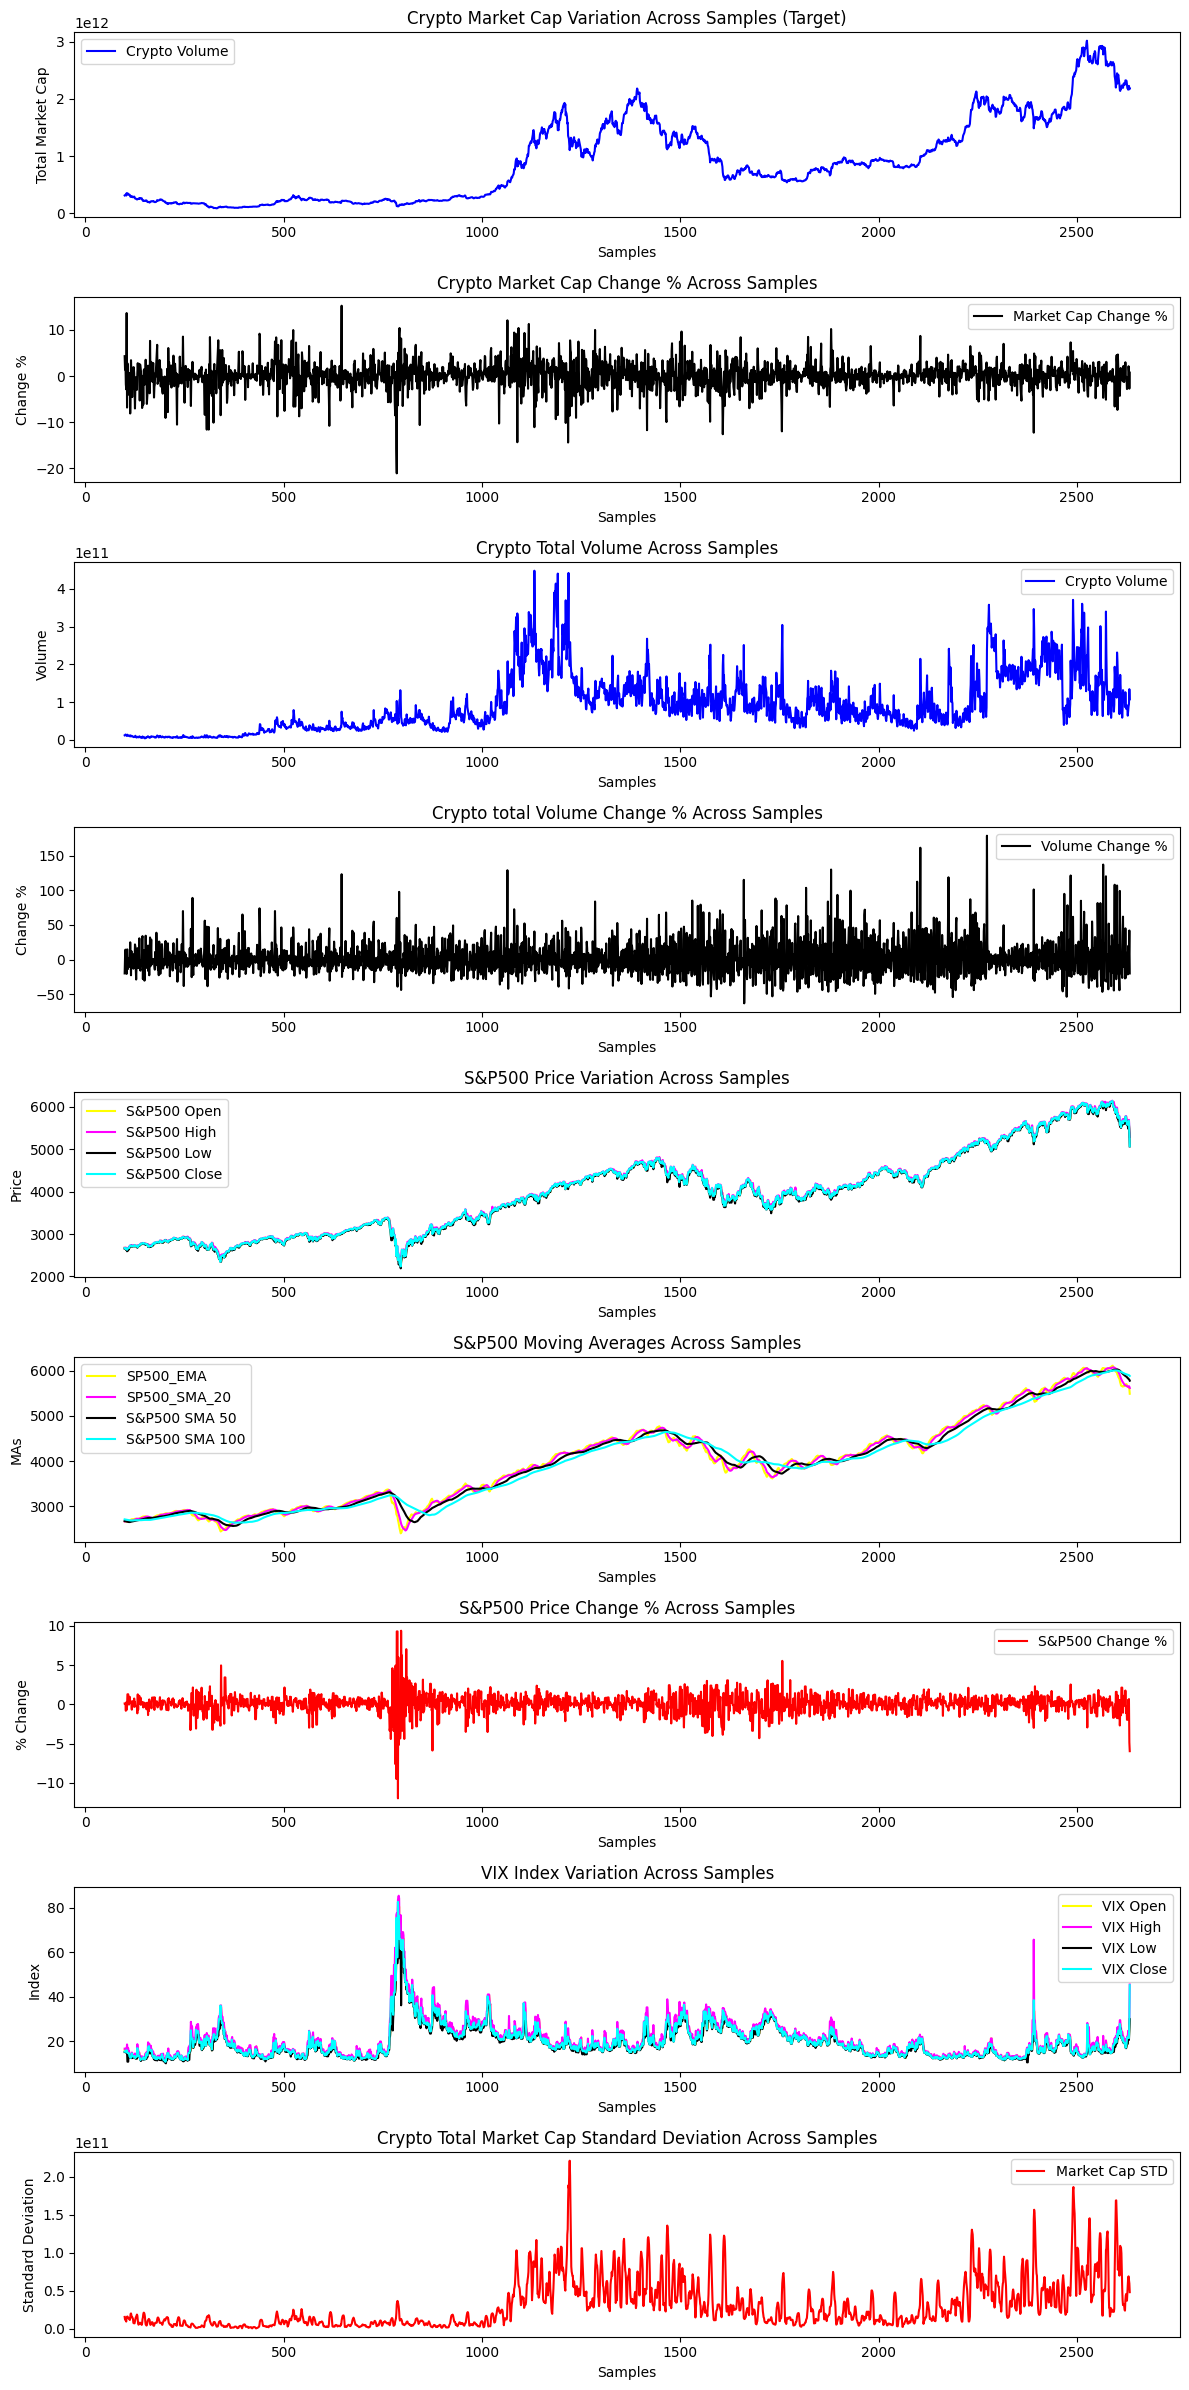

In [27]:
fig, axes = plt.subplots(9, 1, figsize=(12, 24)) 

# First plot: Crypto Total Market Cap (Our Target)
axes[0].plot(main_df.index, main_df['Crypto_Market_Cap'], label='Crypto Volume', color='blue')
axes[0].set_title('Crypto Market Cap Variation Across Samples (Target)')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Total Market Cap')
axes[0].legend()

# Second plot: Crypto Total Market % Change
axes[1].plot(main_df.index, main_df['Crypto_Market_Cap_%'], label='Market Cap Change %', color='black')
axes[1].set_title('Crypto Market Cap Change % Across Samples')
axes[1].set_xlabel('Samples')
axes[1].set_ylabel('Change %')
axes[1].legend()

# Third plot: Crypto Total Volume
axes[2].plot(main_df.index, main_df['Crypto_Volume'], label='Crypto Volume', color='blue')
axes[2].set_title('Crypto Total Volume Across Samples')
axes[2].set_xlabel('Samples')
axes[2].set_ylabel('Volume')
axes[2].legend()

# Fourth plot: Crypto Total Volume % Change
axes[3].plot(main_df.index, main_df['Crypto_Volume_Change_%'], label='Volume Change %', color='black')
axes[3].set_title('Crypto total Volume Change % Across Samples')
axes[3].set_xlabel('Samples')
axes[3].set_ylabel('Change %')
axes[3].legend()

# Fifth plot: S&P500 Prices
axes[4].plot(main_df.index, main_df['S&P500_Open'], label='S&P500 Open', color='yellow')
axes[4].plot(main_df.index, main_df['S&P500_High'], label='S&P500 High', color='magenta')
axes[4].plot(main_df.index, main_df['S&P500_Low'], label='S&P500 Low', color='black')
axes[4].plot(main_df.index, main_df['S&P500_Close'], label='S&P500 Close', color='cyan')
axes[4].set_title('S&P500 Price Variation Across Samples')
axes[4].set_xlabel('Samples')
axes[4].set_ylabel('Price')
axes[4].legend()

# Sixth plot: S&P500 Prices
axes[5].plot(main_df.index, main_df['SP500_EMA'], label='SP500_EMA', color='yellow')
axes[5].plot(main_df.index, main_df['SP500_SMA_20'], label='SP500_SMA_20', color='magenta')
axes[5].plot(main_df.index, main_df['SP500_SMA_50'], label='S&P500 SMA 50', color='black')
axes[5].plot(main_df.index, main_df['SP500_SMA_100'], label='S&P500 SMA 100', color='cyan')
axes[5].set_title('S&P500 Moving Averages Across Samples')
axes[5].set_xlabel('Samples')
axes[5].set_ylabel('MAs')
axes[5].legend()

# Seventh plot: S&P500 % Change
axes[6].plot(main_df.index, main_df['S&P500_Change_%'], label='S&P500 Change %', color='red')
axes[6].set_title('S&P500 Price Change % Across Samples')
axes[6].set_xlabel('Samples')
axes[6].set_ylabel('% Change')
axes[6].legend()

# Eigth plot: VIX Prices
axes[7].plot(main_df.index, main_df['VIX_Open'], label='VIX Open', color='yellow')
axes[7].plot(main_df.index, main_df['VIX_High'], label='VIX High', color='magenta')
axes[7].plot(main_df.index, main_df['VIX_Low'], label='VIX Low', color='black')
axes[7].plot(main_df.index, main_df['VIX_Close'], label='VIX Close', color='cyan')
axes[7].set_title('VIX Index Variation Across Samples')
axes[7].set_xlabel('Samples')
axes[7].set_ylabel('Index')
axes[7].legend()

# Ninth plot: Crypto Total Market Cap Standard Deviation
axes[8].plot(main_df.index, main_df['Market_Cap_STD'], label='Market Cap STD', color='red')
axes[8].set_title('Crypto Total Market Cap Standard Deviation Across Samples')
axes[8].set_xlabel('Samples')
axes[8].set_ylabel('Standard Deviation')
axes[8].legend()

plt.tight_layout()
plt.show()


Additionally, discvering the corelations between variables is also a crucial step. By running the code below, we can see what features are most correlated to out target feature.

**Side note**: Here I decided to use **Spearman correlation** because it is better for predicting crypto market cap changes based on S&P 500. It measures the monotonic relationship between variables rather than assuming a strictly linear one like **Pearson**. Since financial markets often exhibit non-linear dependencies, where crypto and S&P 500 might move in the same general direction but not at a constant rate, Spearman is more robust in capturing such patterns. Additionally, it is less sensitive to outliers, which is crucial in volatile markets like cryptocurrency.

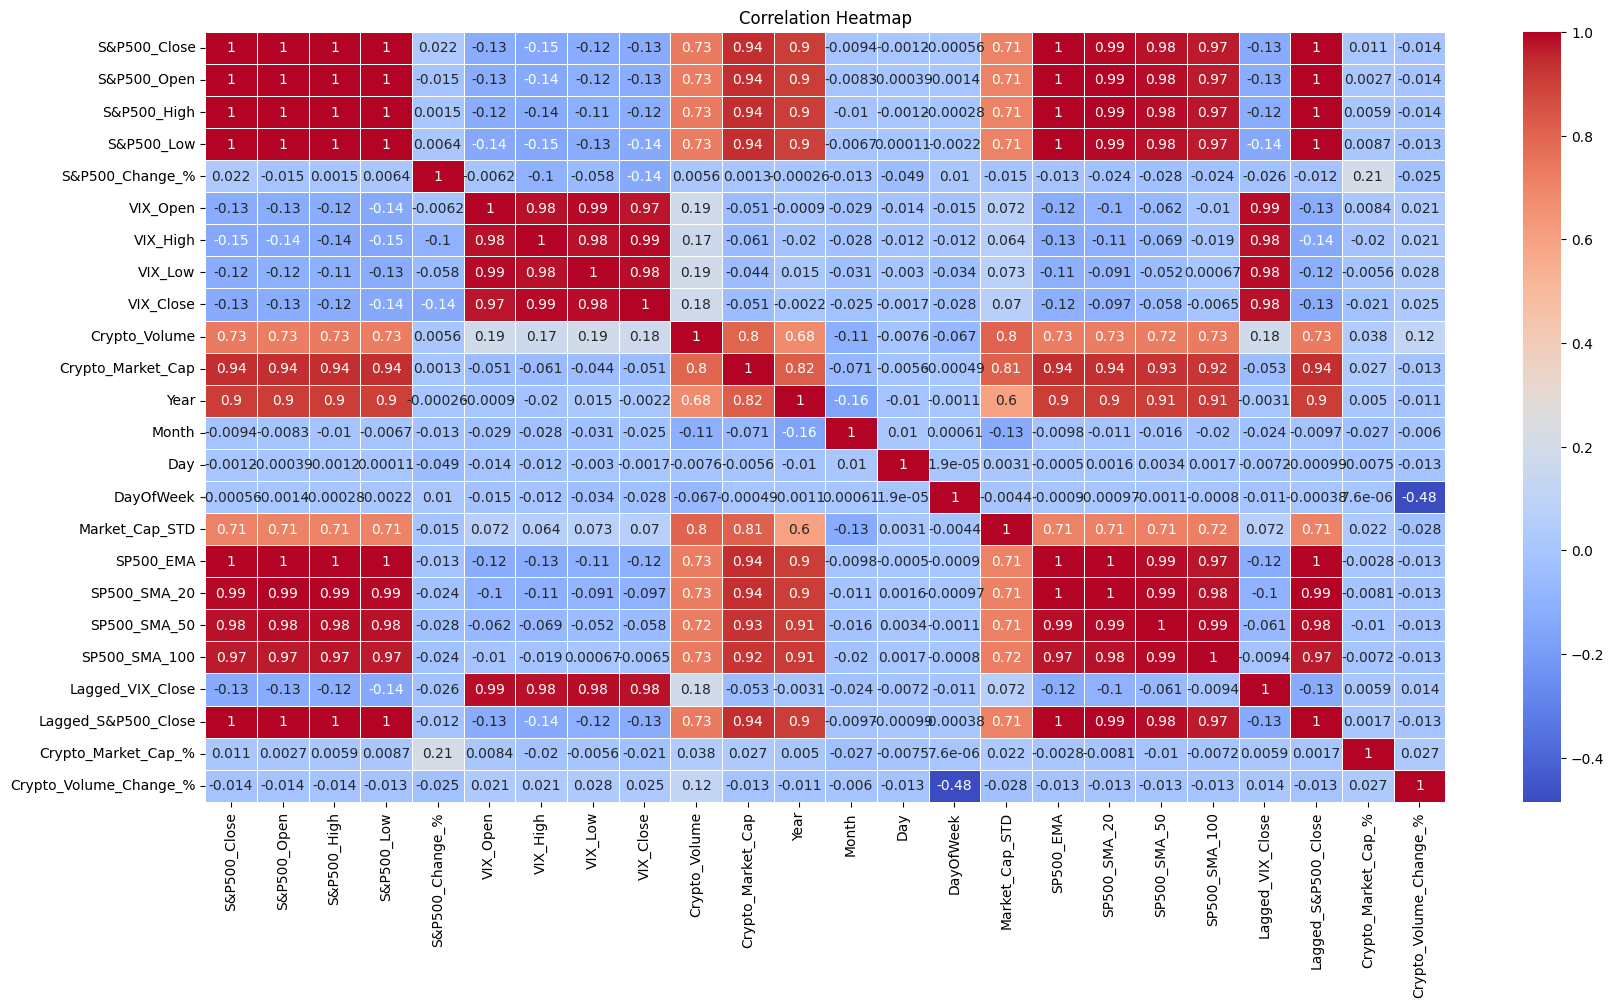

Crypto_Market_Cap         1.000000
S&P500_High               0.938559
S&P500_Close              0.938555
S&P500_Open               0.938501
Lagged_S&P500_Close       0.938486
SP500_EMA                 0.938408
S&P500_Low                0.938342
SP500_SMA_20              0.935829
SP500_SMA_50              0.928754
SP500_SMA_100             0.920803
Year                      0.821114
Market_Cap_STD            0.812101
Crypto_Volume             0.802779
Crypto_Market_Cap_%       0.026623
S&P500_Change_%           0.001327
DayOfWeek                -0.000486
Day                      -0.005637
Crypto_Volume_Change_%   -0.012778
VIX_Low                  -0.044062
VIX_Close                -0.051162
VIX_Open                 -0.051226
Lagged_VIX_Close         -0.052737
VIX_High                 -0.060779
Month                    -0.070776
Name: Crypto_Market_Cap, dtype: float64

In [28]:
df_numeric = main_df.select_dtypes(include=['number'])

plt.figure(figsize=(20, 10))
sns.heatmap(df_numeric.corr("spearman"), linewidths=0.5, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

df_numeric.corr("spearman")["Crypto_Market_Cap"].sort_values(ascending = False)

#### **Data Splitting**

Perfect, now we know that basically all of our features can help predict the crypto market cap!  
Let us prepare splitting the data and standardizing it to train our models by running the code below.

In [29]:
def split_time_series(df: pd.DataFrame, target_col: str, train_ratio: float) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
    """
    Splits the time series dataset into train, validation, and test sets in a sequential manner.

    Args:
        df (pd.DataFrame): The input DataFrame (sorted by date).
        target_col (str): The name of the target column.
        train_ratio (float): The proportion of data to allocate for training (e.g., 0.8 means 80% for train, 10% for validation, 10% for test).

    Returns:
        tuple: DataFrames and Series for train, validation, and test sets (X_train, X_val, X_test, y_train, y_val, y_test).
    """
    # Ensure the data is sorted by time
    df = df.sort_values(by="Date")

    if not (0 < train_ratio < 1):
        raise ValueError("train_ratio must be between 0 and 1.")

    # Define split indices
    train_size = int(len(df) * train_ratio)
    val_size = int(len(df) * ((1 - train_ratio) / 2))

    # Sequential split
    train_data = df.iloc[:train_size]
    val_data = df.iloc[train_size:train_size + val_size]
    test_data = df.iloc[train_size + val_size:]

    # Extract features and target
    X_train, y_train = train_data.drop(columns=[target_col, "Date"]), train_data[target_col]
    X_val, y_val = val_data.drop(columns=[target_col, "Date"]), val_data[target_col]
    X_test, y_test = test_data.drop(columns=[target_col, "Date"]), test_data[target_col]

    return X_train, X_val, X_test, y_train, y_val, y_test


In [30]:
X_train, X_val, X_test, y_train, y_val, y_test = split_time_series(main_df, 'Crypto_Market_Cap', train_ratio=0.70)

feature_scaler = StandardScaler()
target_scaler = StandardScaler()

X_train = feature_scaler.fit_transform(X_train)
X_val = feature_scaler.transform(X_val)
X_test = feature_scaler.transform(X_test)

y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val = target_scaler.transform(y_val.values.reshape(-1, 1))
y_test = target_scaler.transform(y_test.values.reshape(-1, 1))

print("Train shapes:", X_train.shape, y_train.shape)
print("Validation shapes:", X_val.shape, y_val.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (1774, 24) (1774, 1)
Validation shapes: (380, 24) (380, 1)
Test shapes: (381, 24) (381, 1)


### **Model Training**

#### **Utils**

These are a couple of helper functions, and variables that will help us asses our models!

In [81]:
TRAIN_SIZE = len(X_train)
VAL_SIZE = len(X_val)
TEST_SIZE = len(X_test)
TRAIN_INDICES = main_df.index[:TRAIN_SIZE]
VAL_INDICES = main_df.index[TRAIN_SIZE : TRAIN_SIZE + VAL_SIZE]
TEST_INDICES = main_df.index[TRAIN_SIZE + VAL_SIZE:]

def mean_directional_accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculates Mean Directional Accuracy (MDA).
    
    Args:
        y_true (np.ndarray): Actual target values.
        y_pred (np.ndarray): Predicted target values.
    
    Returns:
        float: MDA score between 0 and 1.
    """
    return np.mean(np.sign(np.diff(y_true.flatten())) == np.sign(np.diff(y_pred.flatten())))

def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray) -> dict[str, float]:
    """
    Evaluates the model on different metrics.
    
    Args:
        y_true (np.ndarray): Actual target values.
        y_pred (np.ndarray): Predicted target values.
    
    Returns:
        dict: Dictionary of metric names and their values.
    """

    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²": r2_score(y_true, y_pred),
        "MDA": mean_directional_accuracy(y_true, y_pred)
    }

def print_combined_evaluation_metrics(
    train_results: dict[str, float],
    val_results: dict[str, float],
    test_results: dict[str, float]
) -> None:
    """
    Prints evaluation metrics for train, validation, and test sets in a horizontal format.
    
    Args:
        train_results (dict): Training set metrics.
        val_results (dict): Validation set metrics.
        test_results (dict): Test set metrics.
    """
    print("=" * 75)
    print("📊 Model Evaluation Results (    Train   |   Validation  |   Test    ) 📊")
    print("=" * 75)
    
    all_metrics = sorted(set(train_results) | set(val_results) | set(test_results))
    for metric in all_metrics:
        train_val = train_results.get(metric, float('nan'))
        val_val = val_results.get(metric, float('nan'))
        test_val = test_results.get(metric, float('nan'))
        print(f"➡️ {metric:<24} {train_val:>11.4f}  {val_val:>12.4f}  {test_val:>11.4f}")
    
    print("=" * 75)

def plot_predictions(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    indices: pd.Index,
    title: str
) -> None:
    """
    Plots true vs predicted values.
    
    Args:
        y_true (np.ndarray): Actual target values.
        y_pred (np.ndarray): Predicted target values.
        indices (pd.Index): Indices for the samples.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 4))
    plt.plot(indices, y_true, label='True Values', color='blue')
    plt.plot(indices, y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('Scaled Market Cap')
    plt.legend()
    plt.show()

def plot_loss_curves(train_losses: list, val_losses: list) -> None:
    """
    Plots training and validation loss curves.
    
    Args:
        train_losses (list): List of training losses per epoch
        val_losses (list): List of validation losses per epoch
    """
    plt.figure(figsize=(10, 4))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()

Side note about metrics:
- **MSE/RMSE**: Values closer to 0 indicates higher accuracy.
- **R²**: A score closer to 1 is ideal, meaning the model fits the data well. A negative value indicates poor predictive performance.
- **MDA**: A score above 0.5 suggests better-than-random prediction, while a score close to 1 is ideal.  

Let us define a modular train_model function that we can use in many ways (batching, dropout, etc.)

In [86]:
def train_model(
    model: nn.Module,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    epochs: int = 250,
    batch_size: int = None,
    dropout_rate: float = 0.0,
    print_every: int = 50
) -> tuple[list, list]:
    """Trains the model and returns loss histories.
    
    Args:
        model: Neural network model
        criterion: Loss function
        optimizer: Optimization algorithm
        X_train: Training features
        y_train: Training labels
        X_val: Validation features
        y_val: Validation labels
        epochs: Number of training epochs
        batch_size: Size of training batches (None for full batch)
        dropout_rate: Dropout rate (0.0 for no dropout)
        print_every: Print progress every N epochs
        
    Returns:
        Tuple of (train_losses, val_losses)
    """
    train_losses, val_losses = [], []
    
    # Set dropout rate if model has dropout layers
    if hasattr(model, 'dropout_rate'):
        model.dropout_rate = dropout_rate
    
    # Create DataLoader if batch_size is specified
    if batch_size is not None:
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    else:
        # If no batch_size, use full dataset as single batch
        train_loader = [(X_train, y_train)]
    
    for epoch in range(epochs):
        epoch_train_loss = 0.0
        batch_count = 0
        
        # Training step with potential batching
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            batch_count += 1
        
        avg_train_loss = epoch_train_loss / batch_count
        
        # Validation step (always full batch)
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
        
        # Store losses
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss.item())
        
        if (epoch + 1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{epochs}] ==> Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss.item():.4f}")
    
    return train_losses, val_losses

Also define some common variables and hyperparameters that may be overwritten.

In [143]:
#hyperparameters
input_size = X_train.shape[1]
num_layers = 2                
hidden_size = 32
batch_size = 64
dropout_rate = 0.2
lr = 0.01

# Tensor conversion for training
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

#### **Linear Regression**

Let us start first with a very simple model and see how it performs. Then we can go from there. 

In [87]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim: int, dropout_rate: float = 0.0):
        """
        Linear Regression implemented as a PyTorch Module.
        
        Args:
            input_dim: Number of input features
            dropout_rate: Optional dropout rate (default: 0 = no dropout)
        """
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None
        
    def forward(self, x):
        x = self.linear(x)
        if self.dropout is not None:
            x = self.dropout(x)
        return x

Epoch [50/250] ==> Train Loss: 0.1657, Val Loss: 0.2233
Epoch [100/250] ==> Train Loss: 0.1316, Val Loss: 0.1107
Epoch [150/250] ==> Train Loss: 0.1113, Val Loss: 0.0678
Epoch [200/250] ==> Train Loss: 0.0989, Val Loss: 0.0532
Epoch [250/250] ==> Train Loss: 0.0917, Val Loss: 0.0565
📊 Model Evaluation Results (    Train   |   Validation  |   Test    ) 📊
➡️ MDA                           0.6294        0.6042       0.5605
➡️ MSE                           0.0916        0.0565       0.3364
➡️ RMSE                          0.3026        0.2377       0.5800
➡️ R²                            0.9084        0.8066       0.4251


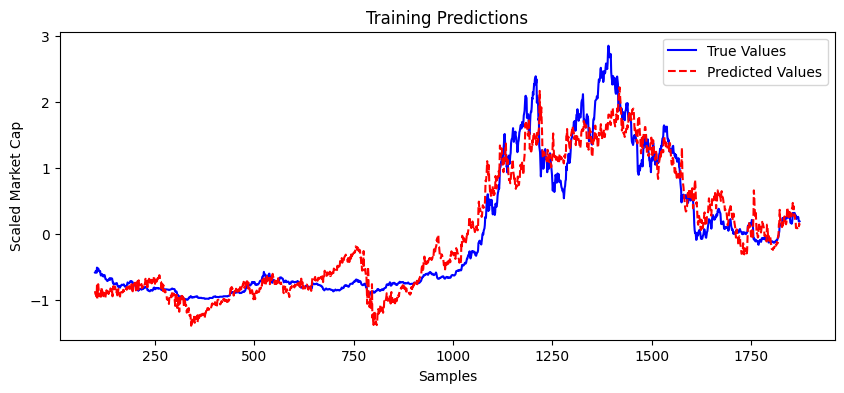

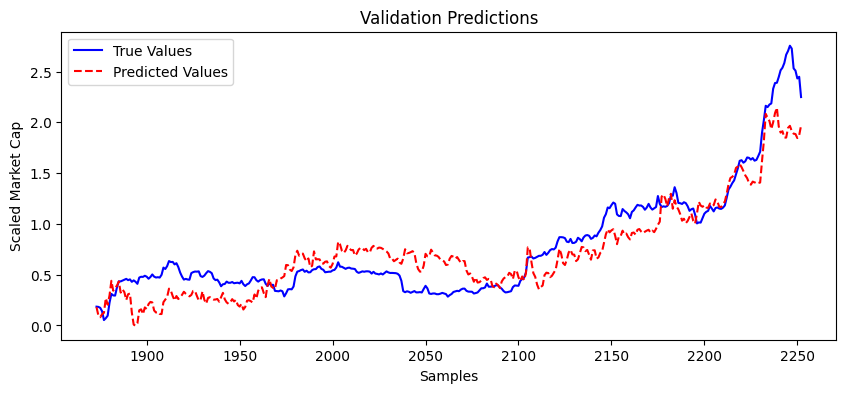

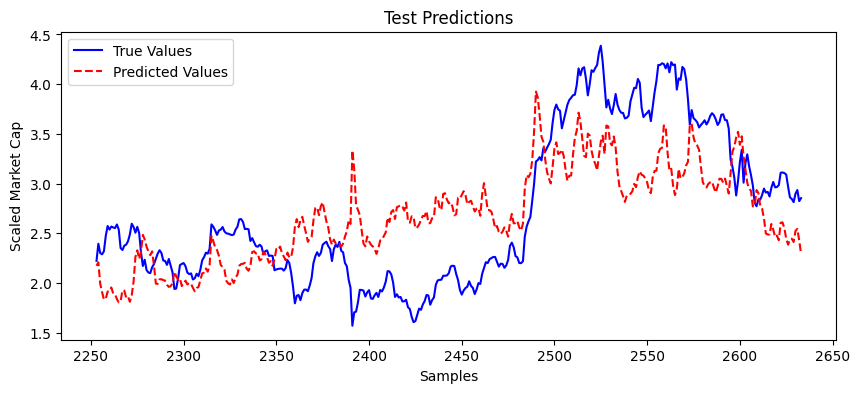

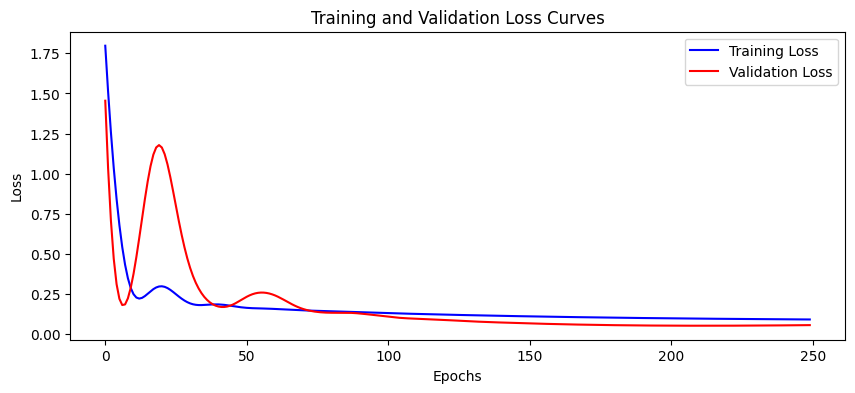

In [120]:
# 1. Initialize model
lin_reg_model = LinearRegressionModel(input_dim=input_size)

# 2. Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lin_reg_model.parameters(), lr=lr)

# 3. Train the model
train_losses, val_losses = train_model(
    model=lin_reg_model,
    criterion=criterion,
    optimizer=optimizer,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_val=X_val_tensor,
    y_val=y_val_tensor,
)

# 4. Evaluate the model on train, validation, and test sets
lin_reg_model.eval()
with torch.no_grad():
    train_pred = lin_reg_model(X_train_tensor)
    val_pred = lin_reg_model(X_val_tensor)
    test_pred = lin_reg_model(X_test_tensor)
    
    train_metrics = evaluate_model(y_train_tensor.detach().numpy(), train_pred)
    val_metrics = evaluate_model(y_val_tensor.detach().numpy(), val_pred)
    test_metrics = evaluate_model(y_test_tensor.detach().numpy(), test_pred)

# 5. Print metric results
print_combined_evaluation_metrics(train_metrics, val_metrics, test_metrics)

# 6. Plot predictions and loss curves
plot_predictions(y_train, train_pred, TRAIN_INDICES, "Training Predictions")
plot_predictions(y_val, val_pred, VAL_INDICES, "Validation Predictions")
plot_predictions(y_test, test_pred, TEST_INDICES, "Test Predictions")
plot_loss_curves(train_losses, val_losses)

Epoch [50/250] ==> Train Loss: 0.0953, Val Loss: 0.0511
Epoch [100/250] ==> Train Loss: 0.0849, Val Loss: 0.0864
Epoch [150/250] ==> Train Loss: 0.0812, Val Loss: 0.1122
Epoch [200/250] ==> Train Loss: 0.0818, Val Loss: 0.1203
Epoch [250/250] ==> Train Loss: 0.0813, Val Loss: 0.1265
📊 Model Evaluation Results (    Train   |   Validation  |   Test    ) 📊
➡️ MDA                           0.6294        0.5752       0.5579
➡️ MSE                           0.0809        0.1265       0.3398
➡️ RMSE                          0.2845        0.3557       0.5829
➡️ R²                            0.9191        0.5668       0.4193


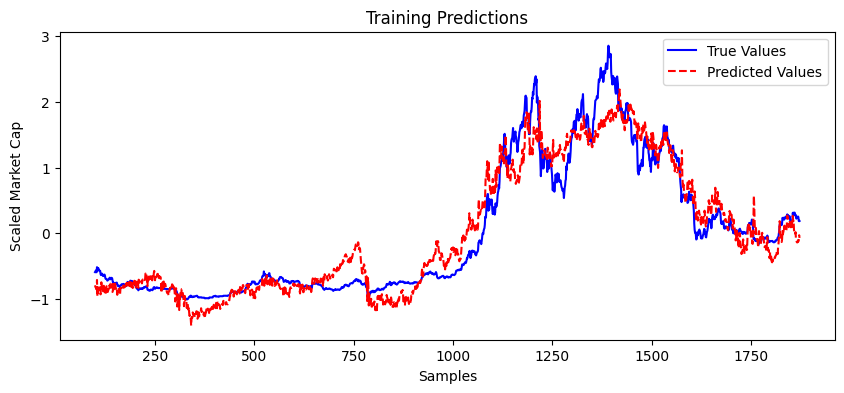

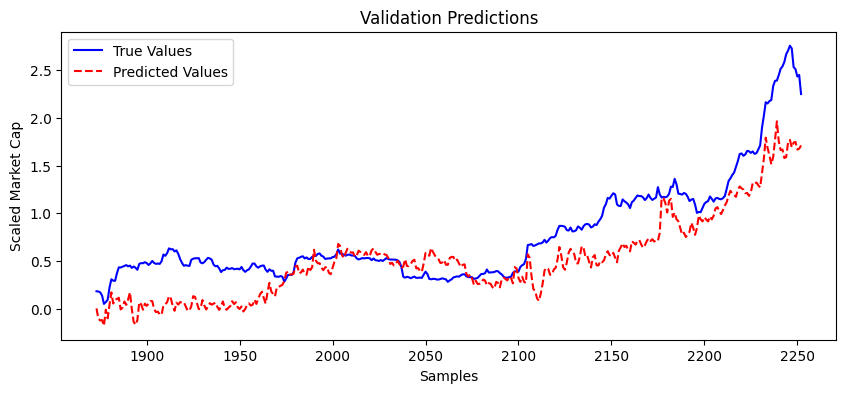

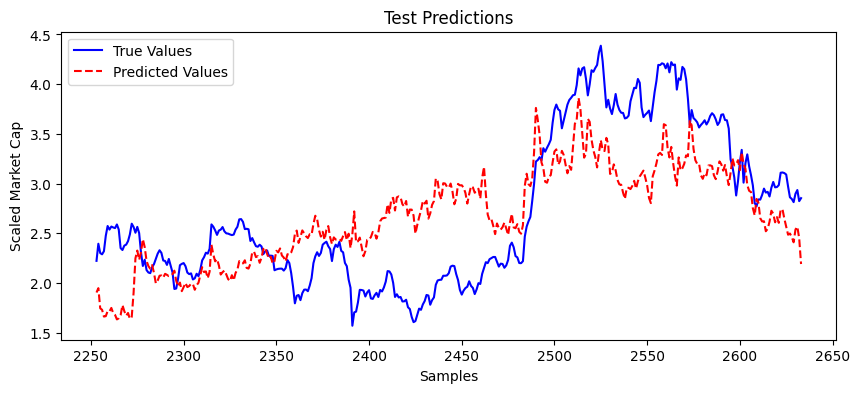

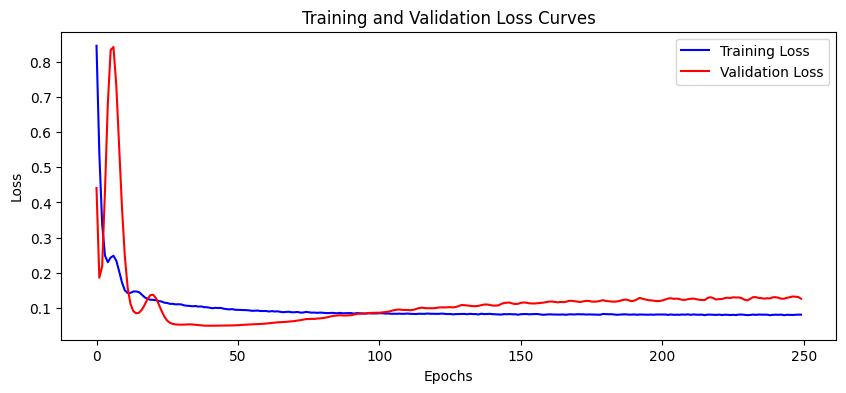

In [126]:
# 1. Initialize model
lin_reg_model = LinearRegressionModel(input_dim=input_size) 

# 2. Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lin_reg_model.parameters(), lr=lr)

# 3. Train the model
train_losses, val_losses = train_model(
    model=lin_reg_model,
    criterion=criterion,
    optimizer=optimizer,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_val=X_val_tensor,
    y_val=y_val_tensor,
    batch_size=1028,
    )

# 4. Evaluate the model on train, validation, and test sets
lin_reg_model.eval()
with torch.no_grad():
    train_pred = lin_reg_model(X_train_tensor)
    val_pred = lin_reg_model(X_val_tensor)
    test_pred = lin_reg_model(X_test_tensor)
    
    train_metrics = evaluate_model(y_train_tensor.detach().numpy(), train_pred)
    val_metrics = evaluate_model(y_val_tensor.detach().numpy(), val_pred)
    test_metrics = evaluate_model(y_test_tensor.detach().numpy(), test_pred)

# 5. Print metric results
print_combined_evaluation_metrics(train_metrics, val_metrics, test_metrics)

# 6. Plot predictions and loss curves
plot_predictions(y_train, train_pred, TRAIN_INDICES, "Training Predictions")
plot_predictions(y_val, val_pred, VAL_INDICES, "Validation Predictions")
plot_predictions(y_test, test_pred, TEST_INDICES, "Test Predictions")
plot_loss_curves(train_losses, val_losses)

#### **ANNs**

Let us move on to a more complex model: **ANNs**  
Run the cell below for some additional helper functions.

In [129]:
class ANNModel(nn.Module):
    def __init__(self, input_size: int, output_size: int = 1, dropout_rate: float = 0.0) -> None:
        super().__init__()
        self.dropout_rate = dropout_rate
        self.dropout = nn.Dropout(dropout_rate)
        self.model = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            # nn.Linear(32, 8),
            # nn.ReLU(),
            nn.Linear(8, output_size)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.dropout(x)
        return self.model(x)

Let us train our second model with the simplest hyperparameters!

Epoch [50/250] ==> Train Loss: 0.5002, Val Loss: 0.2910
Epoch [100/250] ==> Train Loss: 0.1469, Val Loss: 0.4209
Epoch [150/250] ==> Train Loss: 0.1085, Val Loss: 0.3728
Epoch [200/250] ==> Train Loss: 0.0888, Val Loss: 0.3006
Epoch [250/250] ==> Train Loss: 0.0754, Val Loss: 0.2373
📊 Model Evaluation Results (    Train   |   Validation  |   Test    ) 📊
➡️ MDA                           0.5330        0.5699       0.6079
➡️ MSE                           0.0752        0.2373       0.6207
➡️ RMSE                          0.2742        0.4871       0.7878
➡️ R²                            0.9248        0.1877      -0.0608


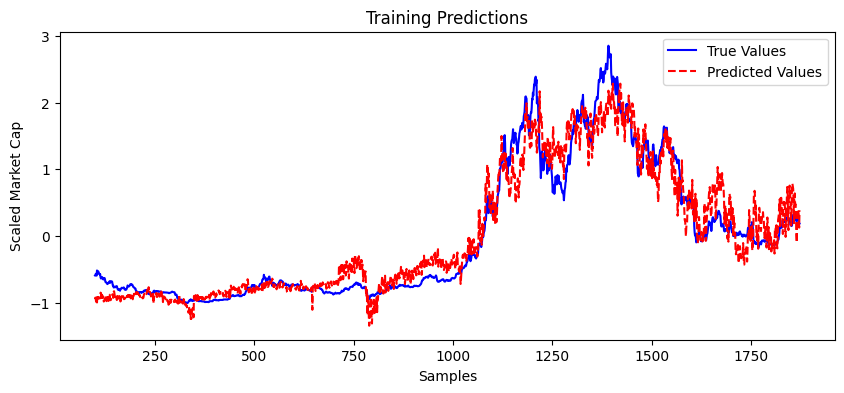

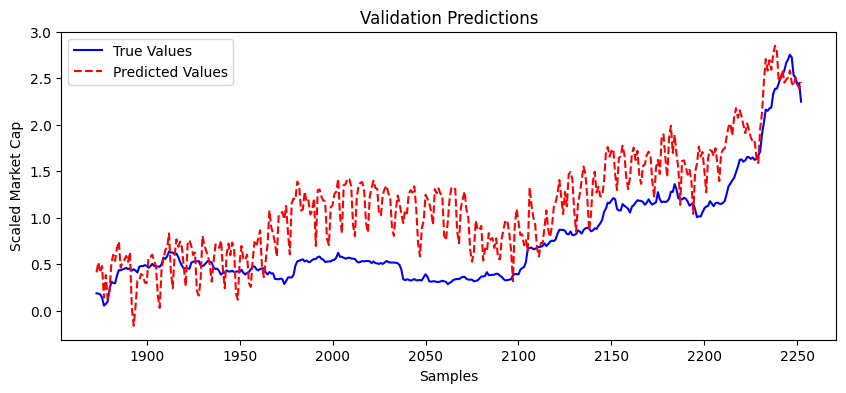

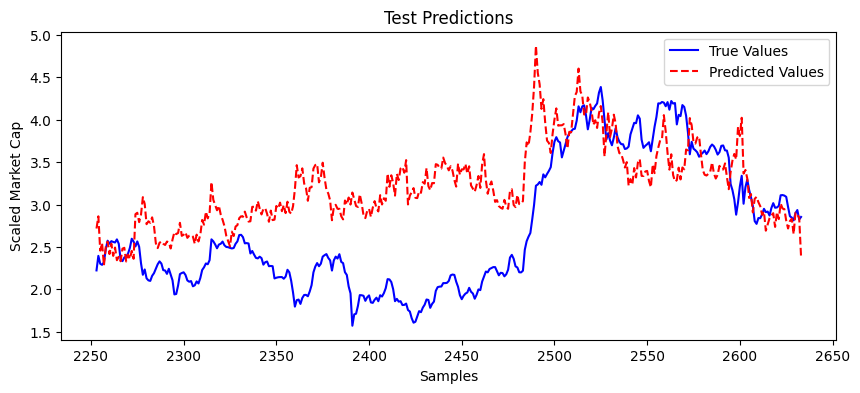

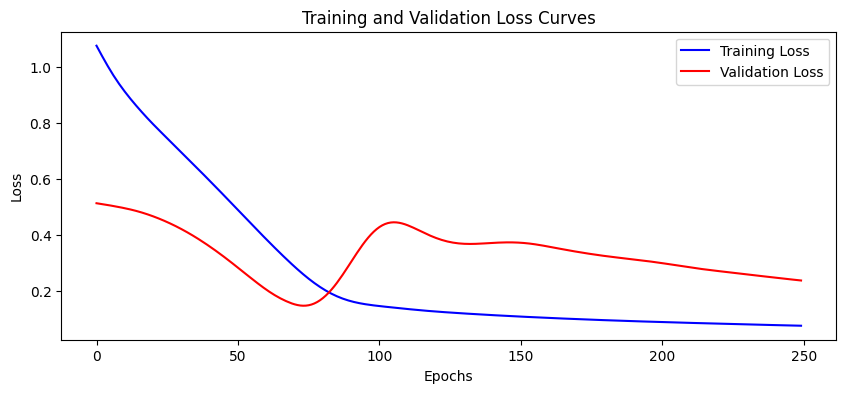

In [130]:
#1. Initialize model
ANN_model = ANNModel(input_size=input_size)

#2. Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(ANN_model.parameters(), lr=lr/10)

#3. Train the model
train_losses, val_losses = train_model(
    model=ANN_model,
    criterion=criterion, 
    optimizer=optimizer,
    X_train=X_train_tensor, 
    y_train=y_train_tensor,
    X_val=X_val_tensor,
    y_val=y_val_tensor,
)

#4. Evaluate the model on train, validation, and test sets
ANN_model.eval()
with torch.no_grad():
    train_pred = ANN_model(X_train_tensor)
    val_pred = ANN_model(X_val_tensor)
    test_pred = ANN_model(X_test_tensor)
    
    train_metrics = evaluate_model(y_train_tensor.detach().numpy(), train_pred)
    val_metrics = evaluate_model(y_val_tensor.detach().numpy(), val_pred)
    test_metrics = evaluate_model(y_test_tensor.detach().numpy(), test_pred)

#5. Print metric results
print_combined_evaluation_metrics(train_metrics, val_metrics, test_metrics)

#6. Plot predictions and loss curves
plot_predictions(y_train, train_pred, TRAIN_INDICES, "Training Predictions")
plot_predictions(y_val, val_pred, VAL_INDICES, "Validation Predictions")
plot_predictions(y_test, test_pred, TEST_INDICES, "Test Predictions")
plot_loss_curves(train_losses, val_losses)

Let's train our third model with some batch size and dropout rate.

Epoch [50/250] ==> Train Loss: 0.0721, Val Loss: 0.1574
Epoch [100/250] ==> Train Loss: 0.0564, Val Loss: 0.1443
Epoch [150/250] ==> Train Loss: 0.0463, Val Loss: 0.1295
Epoch [200/250] ==> Train Loss: 0.0422, Val Loss: 0.0957
Epoch [250/250] ==> Train Loss: 0.0353, Val Loss: 0.0716
📊 Model Evaluation Results (    Train   |   Validation  |   Test    ) 📊
➡️ MDA                           0.6379        0.6491       0.6184
➡️ MSE                           0.0242        0.0716       0.8768
➡️ RMSE                          0.1557        0.2676       0.9364
➡️ R²                            0.9758        0.7548      -0.4984


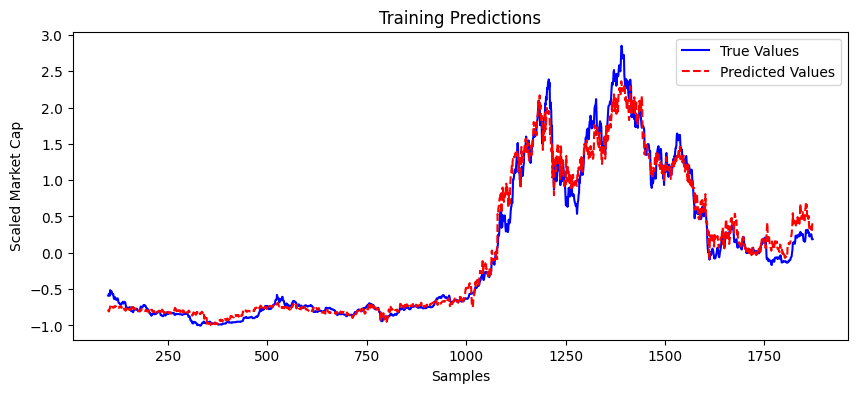

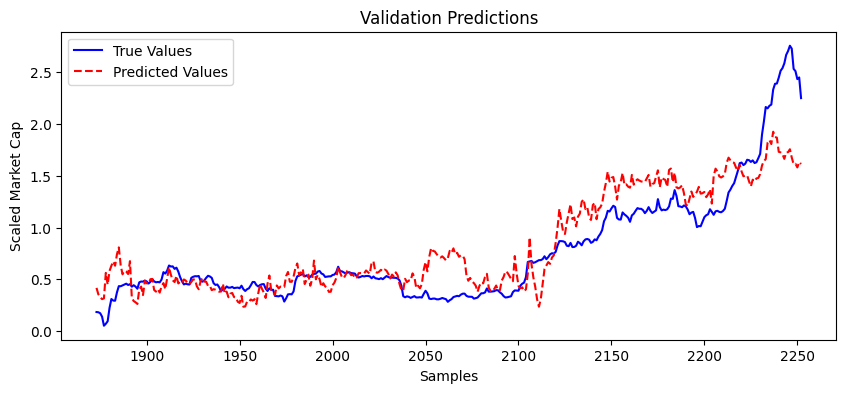

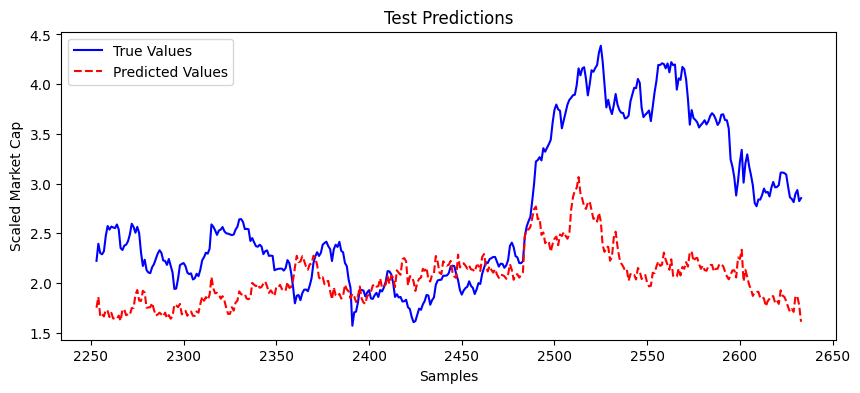

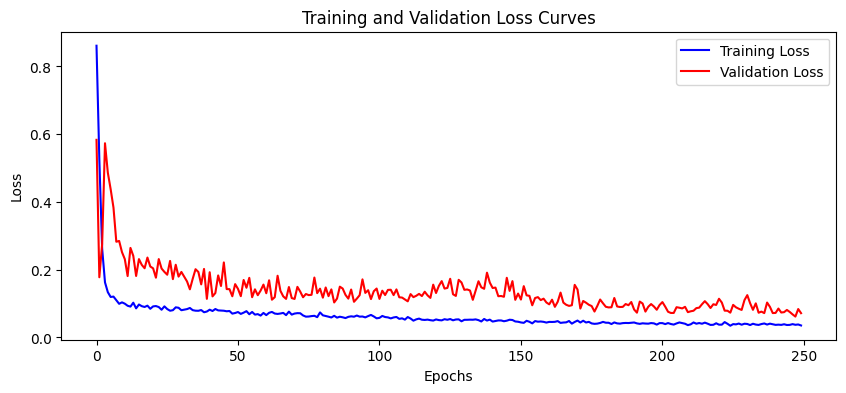

In [132]:
#1. Initialize model
ANN_model = ANNModel(input_size=input_size, dropout_rate=dropout_rate)

#2. Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(ANN_model.parameters(), lr=lr/10)

#3. Train the model
train_losses, val_losses = train_model(
    model=ANN_model,
    criterion=criterion, 
    optimizer=optimizer,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_val=X_val_tensor, 
    y_val=y_val_tensor,
    batch_size=64,

)

#4. Evaluate the model on train, validation, and test sets
ANN_model.eval()
with torch.no_grad():
    train_pred = ANN_model(X_train_tensor)
    val_pred = ANN_model(X_val_tensor)
    test_pred = ANN_model(X_test_tensor)
    
    train_metrics = evaluate_model(y_train_tensor.detach().numpy(), train_pred)
    val_metrics = evaluate_model(y_val_tensor.detach().numpy(), val_pred)
    test_metrics = evaluate_model(y_test_tensor.detach().numpy(), test_pred)

#5. Print metric results
print_combined_evaluation_metrics(train_metrics, val_metrics, test_metrics)

#6. Plot predictions and loss curves
plot_predictions(y_train, train_pred, TRAIN_INDICES, "Training Predictions")
plot_predictions(y_val, val_pred, VAL_INDICES, "Validation Predictions")
plot_predictions(y_test, test_pred, TEST_INDICES, "Test Predictions")
plot_loss_curves(train_losses, val_losses)

#### **RNNs**

Let us now test RNN models such that LSTMs and GRUs.

##### LSTM

In [133]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate through LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: (batch, seq_len, hidden_size)

        # Only use the last time step's output
        out = self.fc(out[:, -1, :])  # (batch, output_size)
        return out


Epoch [50/250] ==> Train Loss: 0.1287, Val Loss: 0.6564
Epoch [100/250] ==> Train Loss: 0.0689, Val Loss: 0.2565
Epoch [150/250] ==> Train Loss: 0.0535, Val Loss: 0.1537
Epoch [200/250] ==> Train Loss: 0.0482, Val Loss: 0.0943
Epoch [250/250] ==> Train Loss: 0.0451, Val Loss: 0.0727
📊 Model Evaluation Results (    Train   |   Validation  |   Test    ) 📊
➡️ MDA                           0.5984        0.5805       0.5421
➡️ MSE                           0.0366        0.0727       0.6932
➡️ RMSE                          0.1914        0.2696       0.8326
➡️ R²                            0.9634        0.7511      -0.1847


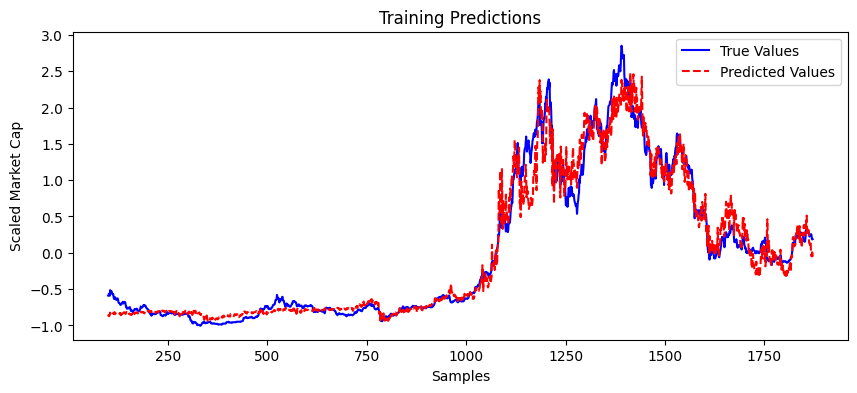

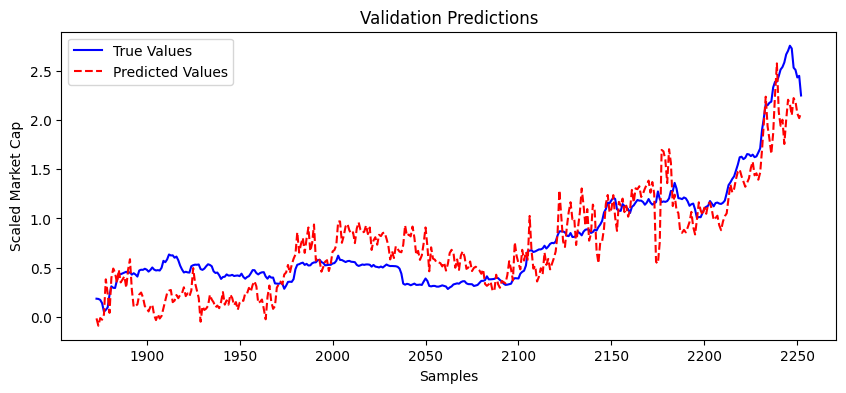

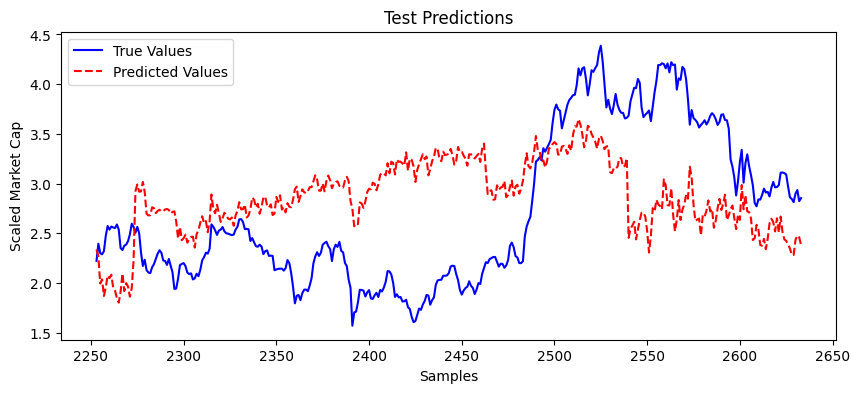

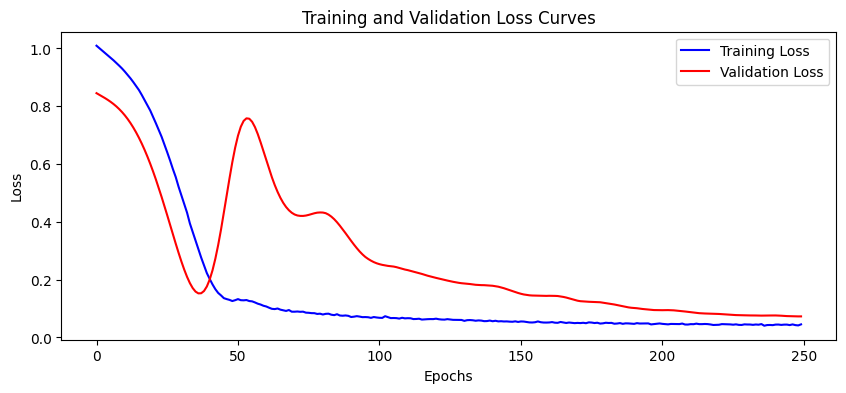

In [ ]:
#1. Initialize model           
lstm_model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=1, dropout=dropout_rate)

#2. Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=lr/10)

#3. Reshape data for LSTM (needs [batch, seq_len, features])
# Since we're doing single-step prediction, seq_len=1
X_train_tensor = X_train_tensor.unsqueeze(1)
X_val_tensor = X_val_tensor.unsqueeze(1)
X_test_tensor = X_test_tensor.unsqueeze(1)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)

#4. Train the model
train_losses, val_losses = train_model(
    model=lstm_model, 
    criterion=criterion, 
    optimizer=optimizer,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_val=X_val_tensor, 
    y_val=y_val_tensor,
)

#5. Evaluate the model on train, validation, and test sets
lstm_model.eval()
with torch.no_grad():
    train_pred = lstm_model(X_train_tensor)
    val_pred = lstm_model(X_val_tensor)
    test_pred = lstm_model(X_test_tensor)
    
    train_metrics = evaluate_model(y_train_tensor.detach().numpy(), train_pred)
    val_metrics = evaluate_model(y_val_tensor.detach().numpy(), val_pred)
    test_metrics = evaluate_model(y_test_tensor.detach().numpy(), test_pred)

#6. Print metric results
print_combined_evaluation_metrics(train_metrics, val_metrics, test_metrics)

#7. Plot predictions and loss curves
plot_predictions(y_train, train_pred.squeeze().numpy(), TRAIN_INDICES, "Training Predictions")
plot_predictions(y_val, val_pred.squeeze().numpy(), VAL_INDICES, "Validation Predictions")
plot_predictions(y_test, test_pred.squeeze().numpy(), TEST_INDICES, "Test Predictions")
plot_loss_curves(train_losses, val_losses)

##### GRU

In [141]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1, dropout=0.0):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate GRU
        out, _ = self.gru(x, h0)  # out: (batch, seq_len, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])  # (batch, output_size)
        return out

Epoch [50/250] ==> Train Loss: 0.1445, Val Loss: 0.3931
Epoch [100/250] ==> Train Loss: 0.0807, Val Loss: 0.3694
Epoch [150/250] ==> Train Loss: 0.0650, Val Loss: 0.1958
Epoch [200/250] ==> Train Loss: 0.0593, Val Loss: 0.1477
Epoch [250/250] ==> Train Loss: 0.0538, Val Loss: 0.1157
📊 Model Evaluation Results (    Train   |   Validation  |   Test    ) 📊
➡️ MDA                           0.5860        0.6069       0.5395
➡️ MSE                           0.0434        0.1157       0.5770
➡️ RMSE                          0.2082        0.3402       0.7596
➡️ R²                            0.9566        0.6038       0.0139


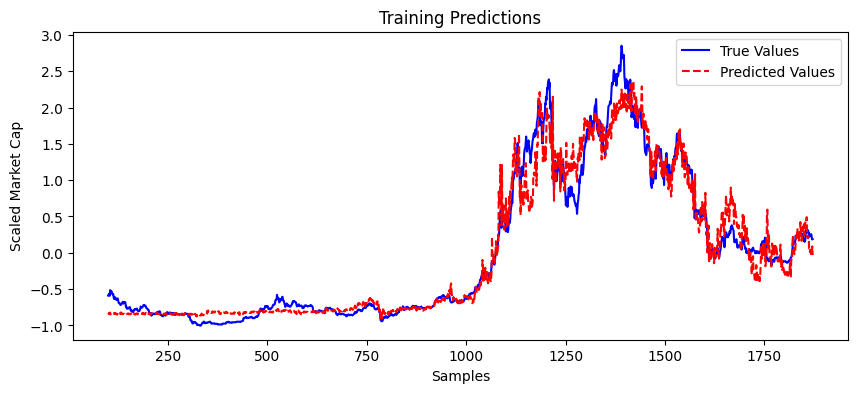

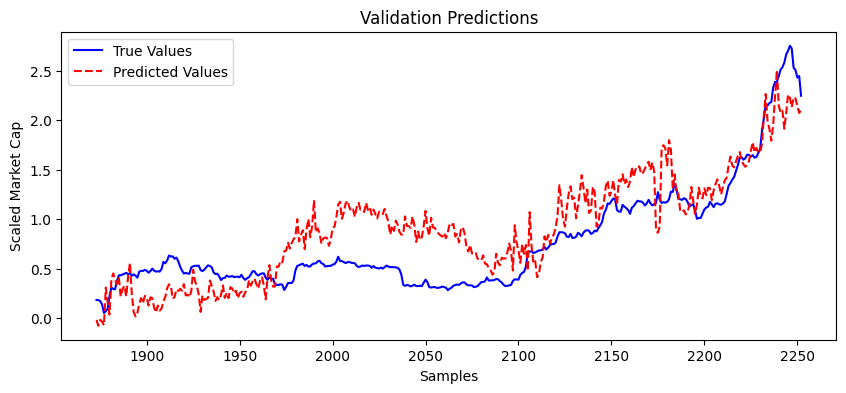

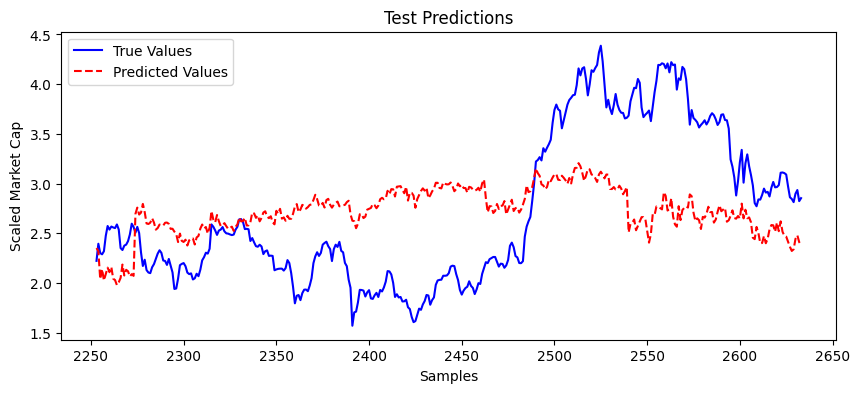

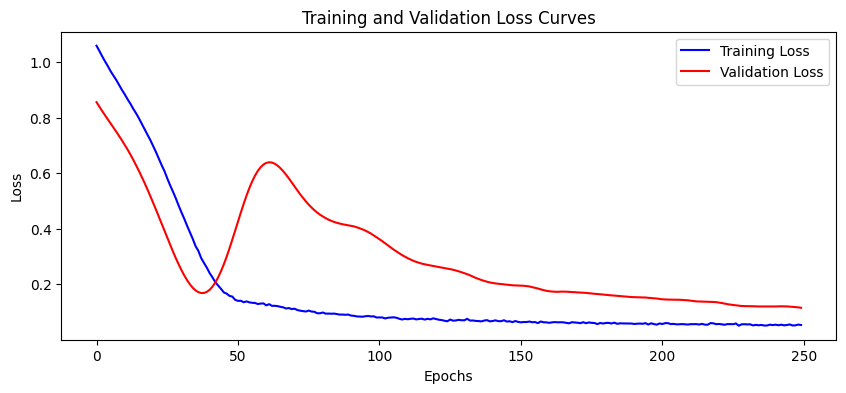

In [145]:
#1. Initialize GRU model
gru_model = GRUModel(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout_rate
)

#2. Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(gru_model.parameters(), lr=lr/10)

#3. Reshape data for gru (needs [batch, seq_len, features])
# Since we're doing single-step prediction, seq_len=1
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)

#4. Train the model
train_losses, val_losses = train_model(
    model=gru_model, 
    criterion=criterion, 
    optimizer=optimizer,
    X_train=X_train_tensor, 
    y_train=y_train_tensor,
    X_val=X_val_tensor, 
    y_val=y_val_tensor,
)

#5. Evaluate the model on train, validation, and test sets
gru_model.eval()
with torch.no_grad():
    train_pred = gru_model(X_train_tensor)
    val_pred = gru_model(X_val_tensor)
    test_pred = gru_model(X_test_tensor)
    
    train_metrics = evaluate_model(y_train_tensor.numpy(), train_pred)
    val_metrics = evaluate_model(y_val_tensor.numpy(), val_pred)
    test_metrics = evaluate_model(y_test_tensor.numpy(), test_pred)

#6. Print metric results
print_combined_evaluation_metrics(train_metrics, val_metrics, test_metrics)

#7. Plot predictions and loss curves
plot_predictions(y_train, train_pred.squeeze().numpy(), TRAIN_INDICES, "Training Predictions")
plot_predictions(y_val, val_pred.squeeze().numpy(), VAL_INDICES, "Validation Predictions")
plot_predictions(y_test, test_pred.squeeze().numpy(), TEST_INDICES, "Test Predictions")
plot_loss_curves(train_losses, val_losses)

## **Experimental Setup**
Describe the datasets used for your experiments. List the machine learning techniques used to solve your problem and report the corresponding hyperparameters.

In this section, you can add **text**, **tables**, and **figures**.

## **Experimental Results**
Describe here the main experimental results. Critically discuss them. Compare them with results available in the literature (if applicable).

In this section, you can add **text** and **figures**, **tables**, **plots**, and code. Make sure the code is runnable and replicable.

## **Conclusions**

Summarize what you could and could not conclude based on your experiments.
In this section, you can add **text**.



## **References**
You can add here the citations of books, websites, or academic papers, etc.

https://medium.com/analytics-vidhya/principal-steps-of-a-machine-learning-project-7d7dcc6fe68b  
https://ishanjainoffical.medium.com/choosing-the-right-correlation-pearson-vs-spearman-vs-kendalls-tau-02dc7d7dd01d  
https://en.wikipedia.org/wiki/Mean_directional_accuracy#:~:text=Mean%20directional%20accuracy%20(MDA)%2C,to%20the%20actual%20realized%20direction.  
https://emojipedia.org/
https://jillanisofttech.medium.com/building-an-ann-with-pytorch-a-deep-dive-into-neural-network-training-a7fdaa047d81  
https://medium.com/data-science-at-microsoft/introduction-to-feature-engineering-for-time-series-forecasting-620aa55fcab0  
https://github.com/AlexanderVNikitin/tsgm/blob/main/tutorials/augmentations.ipynb  
https://medium.com/@mike.roweprediger/using-pytorch-to-train-an-lstm-forecasting-model-e5a04b6e0e67  
https://medium.com/@heriandika/leveraging-moving-average-in-machine-learning-models-03b4a7877f7a  
